In [119]:
# Import statements for machine learning and image classification
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from pathlib import Path
from sklearn.metrics import classification_report

In [120]:
# Get file directory of images
data_dir = Path('../Images/chest_xray/All')

In [121]:
# Print total number of images
image_count = len(list(data_dir.glob('*/*.jpeg')))
print(image_count)

5856


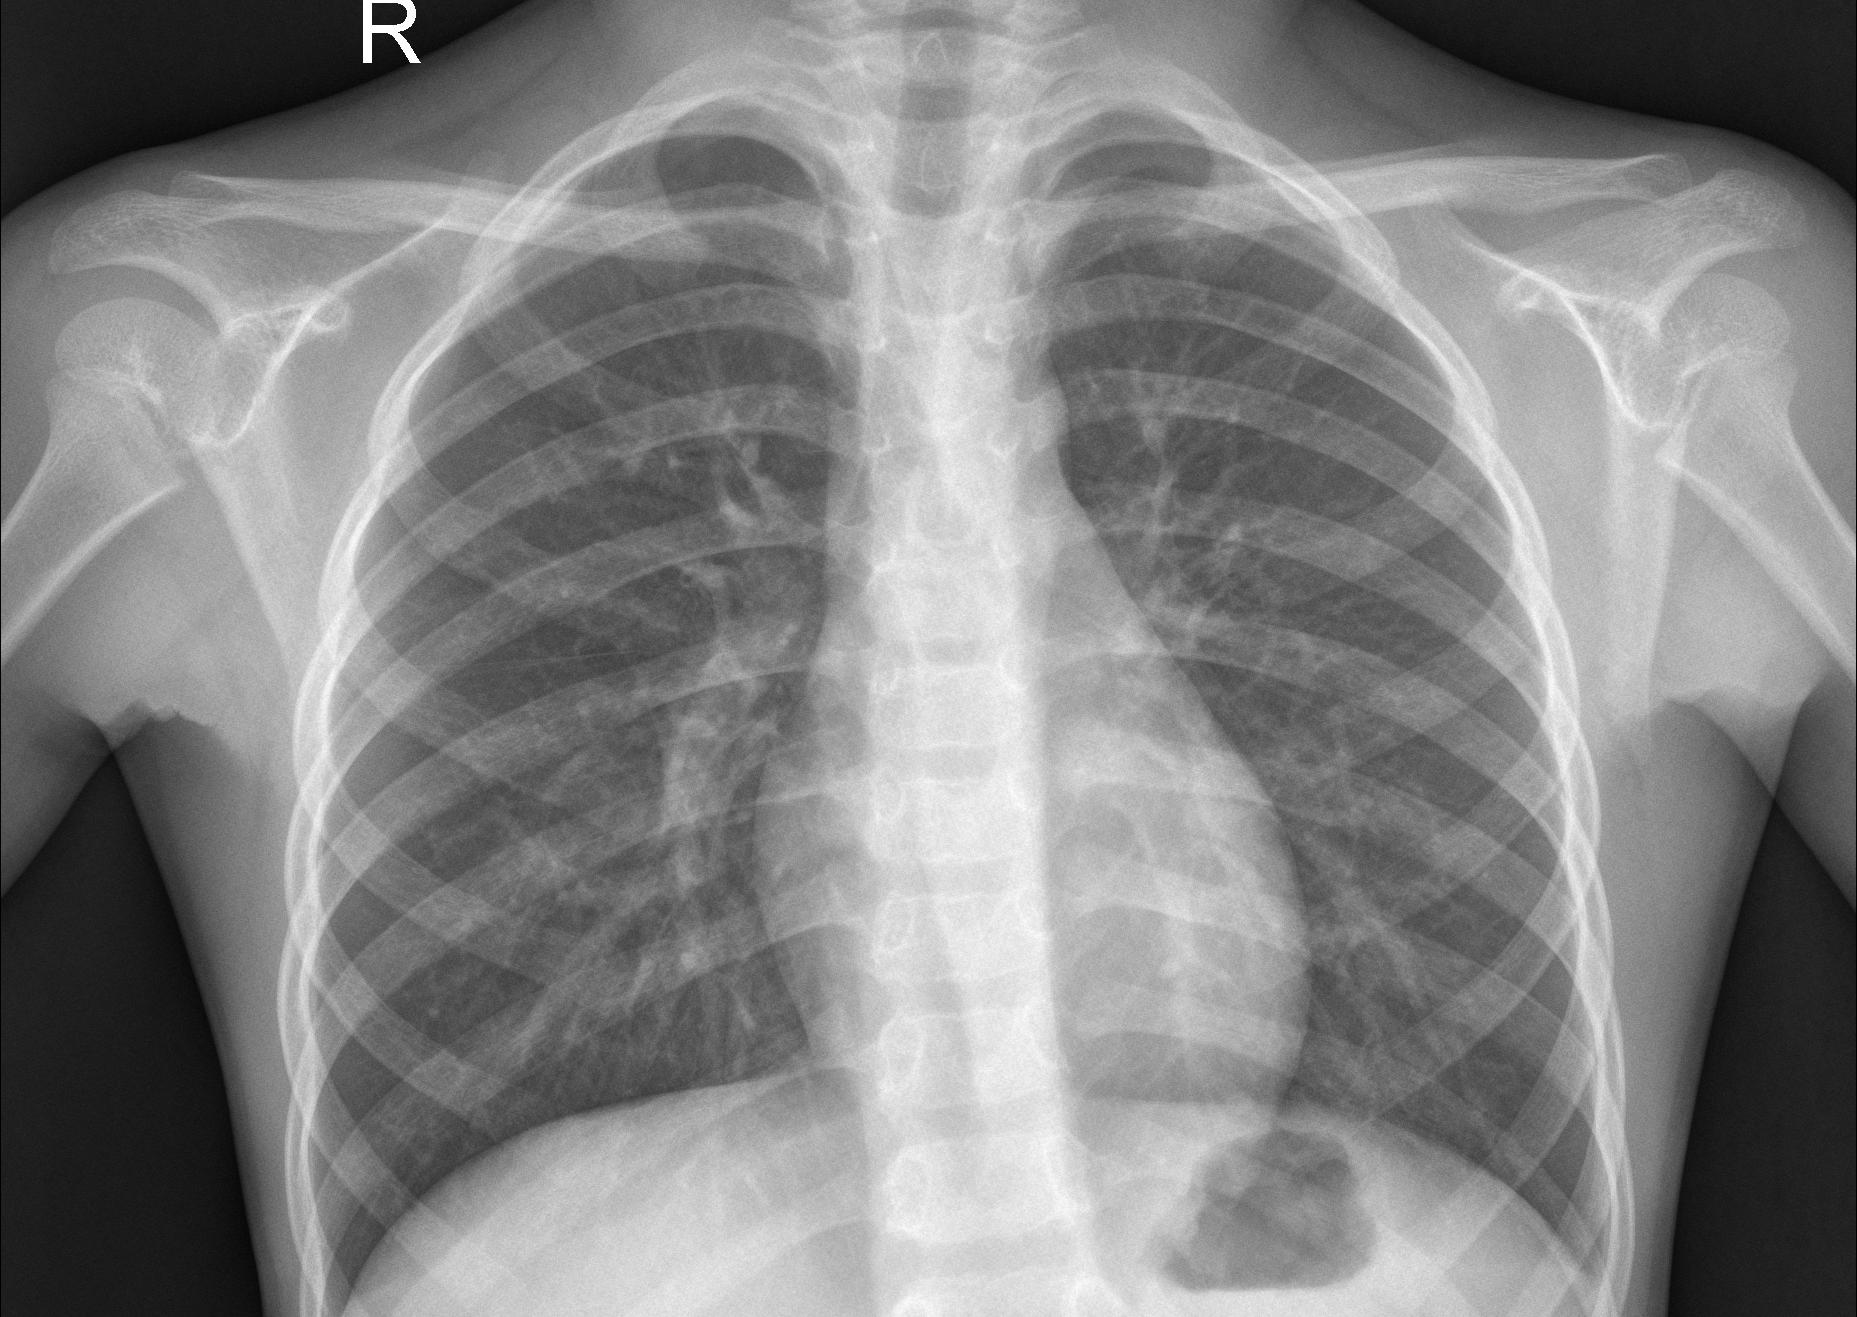

In [122]:
# Show Normal Lungs
normal_lungs = list(data_dir.glob('NORMAL/*'))
PIL.Image.open(str(normal_lungs[0]))

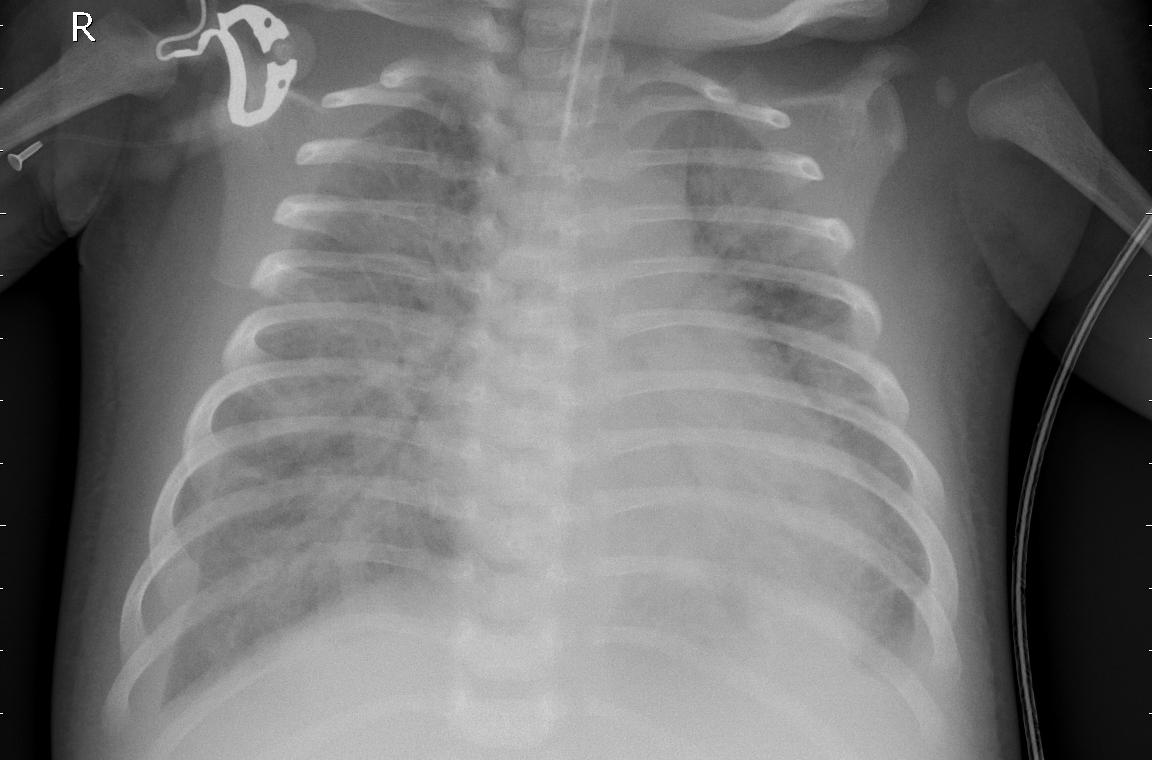

In [123]:
# Show Pneumonia Lungs
pneumonia_lungs = list(data_dir.glob('PNEUMONIA/*'))
PIL.Image.open(str(pneumonia_lungs[0]))

In [124]:
# Define parameters
batch_size = 32
img_height = 180
img_width = 180

In [140]:
# Preprocess Training Data
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle=True)

Found 5856 files belonging to 2 classes.
Using 4685 files for training.


In [141]:
# Preprocess Testing Data
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle=True)

Found 5856 files belonging to 2 classes.
Using 1171 files for validation.


In [127]:
# Show different outcomes
class_names = train_ds.class_names
print(class_names)

['NORMAL', 'PNEUMONIA']


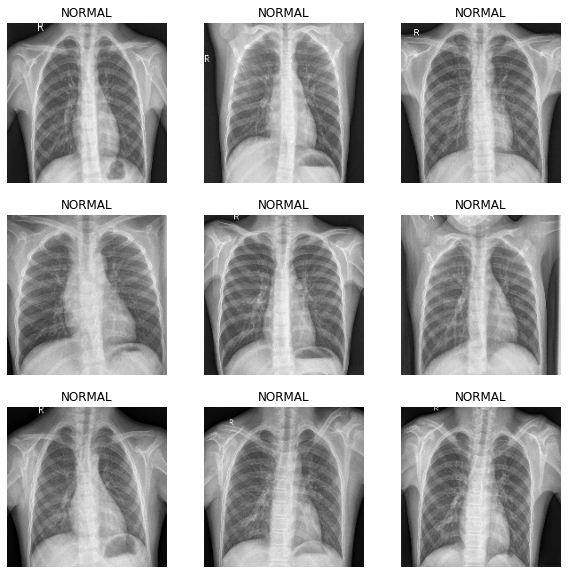

In [128]:
# Show sample of 9 images
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [129]:
# For context of LEARNING this is the shape of the objects
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break
    
'''The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

You can call .numpy() on the image_batch and labels_batch tensors to convert them to a numpy.ndarray'''

(32, 180, 180, 3)
(32,)


'The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.\n\nYou can call .numpy() on the image_batch and labels_batch tensors to convert them to a numpy.ndarray'

In [130]:
# Configuring the data for performance
# AUTOTUNE = tf.data.AUTOTUNE

# train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [131]:
# Normalize data
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [132]:
# Alternative way to normalization
# normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
# image_batch, labels_batch = next(iter(normalized_ds))
# first_image = image_batch[0]
# # Notice the pixels values are now in `[0,1]`.
# print(np.min(first_image), np.max(first_image))

In [142]:
# Creating a model
num_classes = 2

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [143]:
# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [144]:
# Model summary
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_13 (Rescaling)     (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 22, 22, 64)       

In [145]:
# Use class weights to balance model inputs
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
# weight_for_0 = (1 / neg)*(total)/2.0 
# weight_for_1 = (1 / pos)*(total)/2.0

weight_for_0 = 0.70
weight_for_1 = 0.30

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.70
Weight for class 1: 0.30


In [146]:
# Traing the model
epochs=3
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  class_weight=class_weight
)

Epoch 1/3
147/147 [==============================] - 83s 563ms/step - loss: 0.1457 - accuracy: 0.8617 - val_loss: 0.1354 - val_accuracy: 0.9496
Epoch 2/3
147/147 [==============================] - 84s 570ms/step - loss: 0.0750 - accuracy: 0.9351 - val_loss: 0.1311 - val_accuracy: 0.9513
Epoch 3/3
147/147 [==============================] - 83s 567ms/step - loss: 0.0555 - accuracy: 0.9481 - val_loss: 0.1214 - val_accuracy: 0.9547


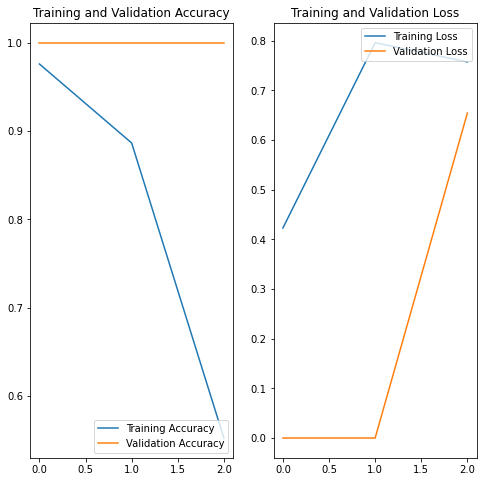

In [139]:
# Visualize the model
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [26]:
# Saving the Model
model_name = 'basic_model-1-16-21'
model_path = Path(f'../Models/{model_name}')

# tf.keras.models.save_model(model_path)
model.save(model_path)


# Code for loading a model
# model = tf.keras.models.load_model(model_path)

INFO:tensorflow:Assets written to: ..\Models\basic_model-1-16-21\assets


In [37]:
# Overfitting Advice
'''In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of overfitting.

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use data augmentation and add Dropout to your model.'''

"In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of overfitting.\n\nWhen there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.\n\nThere are multiple ways to fight overfitting in the training process. In this tutorial, you'll use data augmentation and add Dropout to your model."

In [17]:
# Use data augmentation to help with overfitting
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

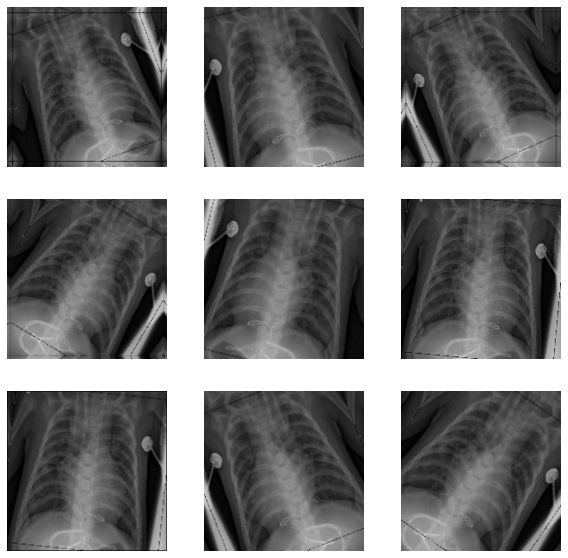

In [18]:
# Show what data augmentation is
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [19]:
# Dropout data to help with overfitting
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [20]:
# Compile the model again
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
# Model summary 2.0
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_3 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 45, 45, 64)       

In [ ]:
# Retrain improved model
epochs = 100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

In [23]:
# Visualize the new model statistics
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

NameError: name 'history' is not defined

In [47]:
# Saving the Model
model_name = 'advanced_model-1-16-21'
model_path = Path(f'../Models/{model_name}')

# tf.keras.models.save_model(model_path)
model.save(model_path)

INFO:tensorflow:Assets written to: ..\Models\advanced_model-1-16-21\assets


In [78]:
# Load desired model
model_name = 'advanced_model-1-16-21'
model_path = Path(f'../Models/{model_name}')
model = tf.keras.models.load_model(model_path)

In [84]:
# Make predictions using test data
# Classification Report

# img_array = val_ds

predictions = model.predict_classes(val_ds)

# test_predictions = np.argmax(model.predict(val_ds), axis=-1)


# predictions = model.predict_classes(val_ds)
# predictions = predictions.reshape(1,-1)[0]
# print(classification_report(y_test, predictions, target_names = ['PNEUMONIA','NORMAL']))

In [85]:
print(predictions)

[0 0 1 ... 0 1 0]


In [51]:
# Predict on the new model
final_test_path = Path('../Images/chest_xray/val/pneumonia/person1946_bacteria_4874.jpeg')
# final_test_path = Path('C:/Users/Eli/Desktop/test_lung.jpeg')

img = keras.preprocessing.image.load_img(
    final_test_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to PNEUMONIA with a 98.93 percent confidence.
